In [14]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

In [30]:
INPUT_WIDTH = 800
INPUT_HEIGHT = 400

in_points = np.array([[x, y] for x in range(INPUT_WIDTH) for y in range(INPUT_HEIGHT)])
in_points.shape

(320000, 2)

In [33]:
N_points = 13

kmeans = KMeans(n_clusters=N_points, random_state=0)
clusters = kmeans.fit_predict(in_points)
new_points = np.array([np.mean(in_points[clusters == curr], axis=0) for curr in set(clusters)])
new_points.shape

(13, 2)

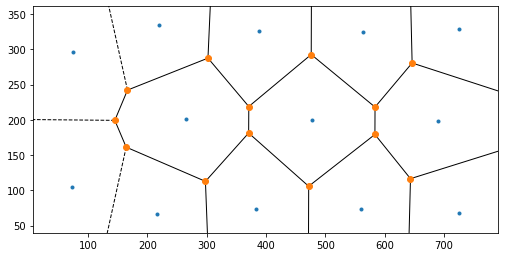

In [34]:
vor = Voronoi(new_points)
fig = voronoi_plot_2d(vor)
fig.set_size_inches(INPUT_WIDTH/96.0, INPUT_HEIGHT/96.0)